# 01 Network Approach to RNA-seq and Lesion data from Botrytis-Arabidopsis infection

The basic idea is that there are 96 Botrytis strains that were used to infect 3 seperate Arabidopsis genotypes. 

The following Notebook imports the data and describes the basic Metadata, the variable we want to predict (Lesion), and the data we want to use to do the prediction (RNA-seq). 


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.insert(0, '..')  # add parent folder path where lib folder is
from atbotml.custom_fuctions import *

# themes
sns.set_theme(style="white")

In [2]:
df = pd.read_csv("../data/LesionAtBcNormTPMReadsStarMapAtBc.csv")

## Notebook parameters

In [3]:
nb_id = '01'
num_classes = 10
random_state = 42

## Meta-data description
There are 29107 columns in the dataframe

In [4]:
len(df.columns)

29107

In [5]:
df['Isolate'].value_counts()

1.05.16      22
Fresa 525    12
1.03.20      12
1.03.04      12
Apple 404    12
             ..
1.02.04       9
1.01.02       9
1.02.20       9
BMM           9
Kern A2       9
Name: Isolate, Length: 96, dtype: int64

In [12]:
df.head()

,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,at1g01046,AT1G01050,...,Bcin18g00020,Bcin18g00060,Bcin18g00145,Bcin18g00180,Bcin18g00190,EFBcT00000013145,EFBcT00000013262,EFBcT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.0,0.000000,21.373592,...,0.0,0.000000,0.000000,0.0,0.000000,12.438875,0.000000,0.000000,0.0,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.0,0.000000,119.029216,...,0.0,0.000000,0.000000,0.0,0.000000,15.521645,0.000000,0.000000,0.0,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.0,0.000000,58.388002,...,0.0,0.000000,0.000000,0.0,0.000000,76.250891,0.000000,0.000000,0.0,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.0,1.000161,19.548414,...,0.0,0.000000,0.000000,0.0,0.000000,41.388120,73.847835,53.937879,0.0,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.0,0.000000,99.136624,...,0.0,15.577566,32.042486,0.0,24.233666,47.555802,0.000000,54.228767,0.0,0.000000


Columns 0, 1, 2, 3, 4 are metadata, termed **Index**, **LibraryID**, **HostGenoType**, **Sample**, and **Isolate**. 

In [13]:
df.iloc[0:5,0:5]

,Index,LibraryID,HostGenoType,Sample,Isolate
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04


**Index** is an identifier for the Arabidopsis genotype by Botrytis isolate infection. There are 288 combinations, which is 3 * 96 (host genotypes * botrytis isolate). 

**Library ID** is a unique identifier associated with each of the individual RNA-seq experiments. There are a total of 1092 unique RNA-seq data sets. 

**NOTE**

Column 5 is the **Lesion** size data. Lesion size is a quantitative measure of disease and is the the output data for each experiment. This is the data that we want to predict. 

**JCS**: All **Lesion** value are the same for each **Index**. 

In [7]:
len(df.iloc[:,[0,5]].groupby('Index').describe())
df.iloc[:,[0,5]].groupby('Index').describe()

df.iloc[:,[1]].describe()

,LibraryID
count,1092
unique,1092
top,npr.1.G1E.21
freq,1


**HostGenoType** is one of 

1. **coi1** with 367 samples 
2. **col0** with 356 samples
3. **npr1** with 369 samples

**NOTE**

There should be 384 samples for each of the host genotypes (96 isolates * 4 replicates). You can see each host genotype is below this max number because of samples that were filtered. 

In [8]:
df.iloc[:,[2,5]].groupby('HostGenoType').describe()

Lesion                                                        \
              count       mean        std       min        25%        50%   
HostGenoType                                                                
coi1          367.0  37.544150  13.180445  2.595268  30.492295  36.857300   
col0          356.0  16.607496   6.510923  4.854255  11.894846  15.232061   
npr1          369.0  21.233408   8.260971  3.169601  16.569677  19.930567   

                                    
                    75%        max  
HostGenoType                        
coi1          44.184041  68.466765  
col0          19.751891  39.652195  
npr1          25.354043  40.387241

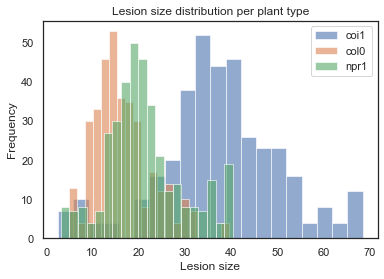

In [9]:
sns.set_theme(style="white")

plant_types = ['coi1', 'col0', 'npr1']

bins = 20
alpha = 0.6

for plant_type in plant_types:
    df.loc[df['HostGenoType'] == plant_type, 'Lesion'].plot.hist(bins=bins, alpha=alpha)

plt.legend(plant_types)
plt.title('Lesion size distribution per plant type')
plt.xlabel('Lesion size')

plt.savefig('./figures/01_AtTypeLesionDist.pdf')
plt.show()

**Sample** and **Isolate** are both descriptions of the Botrytis fungus. 

**Sample** is a numeric code ranging from 1 to 97. Please note, there is no strain 96, it was dropped from the experiment. So, there are 96 total isolates. 

**Isolate** is a more human readable description that is more commonly used in literature. 


**NOTES**

Sample 97, which is isolate 1.05.16, has 22 RNA-seq samples for it. This is for some other reasons. We decided to include them, even though it makes the data a bit more unbalanced. But we can select the data down to only 12 samples if that is important. 

There should in theory be 12 RNA-seq libraries for each sample. That is, 4 reps on each of the 3 host genotypes. But you can see the isolates range from 9 to 12 libraries (except 1.05.16 as explained above). The reason there are not exactly 12 of each is because some experiments or RNA-seq replicates failed and have been filtered from this data set. 

In [10]:
df.iloc[:,[3,5]].groupby('Sample').describe()
df[['Isolate', 'Lesion']].groupby('Isolate').describe()

Lesion                                                         \
               count       mean        std        min        25%        50%   
Isolate                                                                       
1.01.01         12.0  22.864854  10.222324  14.454036  14.454036  17.550522   
1.01.02          9.0  12.107601   5.762051   8.147588   8.147588  10.763382   
1.01.03         12.0  22.746175   9.142122  12.869554  12.869554  21.222322   
1.01.04         11.0  24.839897  14.608714  14.267679  14.267679  14.368083   
1.01.06         11.0  21.593357   7.093568  14.633464  14.633464  20.956333   
...              ...        ...        ...        ...        ...        ...   
Rose            10.0  17.635508   7.198433  10.016489  11.128169  14.463210   
Supersteak      12.0  22.105968   9.925356  14.269065  14.269065  16.569677   
Triple 3 (T3)   12.0  25.825039   8.337663  18.234715  18.234715  22.383101   
Triple 7 (T7)   12.0  29.170410  12.415236  18.097083  18.097083  23.753721   
UK razz         11.0  25.479483  10.048224  15.150773  15.150773  25.354043   

                                     
                     75%        max  
Isolate                              
1.01.01        36.590004  36.590004  
1.01.02        10.763382  22.043955  
1.01.03        34.146650  34.146650  
1.01.04        43.265976  43.265976  
1.01.06        26.339456  31.722579  
...                  ...        ...  
Rose           25.728996  25.728996  
Supersteak     35.479162  35.479162  
Triple 3 (T3)  36.857300  36.857300  
Triple 7 (T7)  45.660426  45.660426  
UK razz        32.386196  39.418350  

[96 rows x 8 columns]

## Data to predict

As noted above, column 5, (which is the 6th column, python starts at 0 numbering), is **Lesion** size. This is the final output from the experiment and represents how severe the disease was. 

This is what we want to predict from the RNA-seq data. We have left the data as a quantitative measure for now. We can turn it into a chategorical variable (i.e. low, medium, high disease) in the future. But, I am worried there would be signigicantly confounded predictions based on the host genotypes. I think this could create some problem with the prediction. 

In [12]:
df.iloc[:,[5]].describe().T

,count,mean,std,min,25%,50%,75%,max
Lesion,1092.0,25.20705,13.257592,2.595268,15.232061,21.764053,34.116404,68.466765


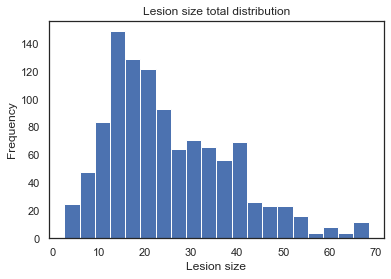

In [13]:
bins = 20
alpha = 0.6

df.loc[:, 'Lesion'].plot.hist(bins=bins)

# for plant_type in plant_types:
#     df.loc[df['HostGenoType'] == plant_type, 'Lesion'].plot.hist(bins=bins, alpha=alpha)

plt.title('Lesion size total distribution')
plt.xlabel('Lesion size')

plt.savefig('./figures/01_LesionDist.pdf')
plt.show()

## RNA-seq data

Columns 6 till the end are the genes. There are genes for both the host (Arabidopsis) and the pathogen (Botrytis). Each of the 1092 experiments (rows) has counts for each of the genes (columns 6-29107).

In [14]:
df.iloc[0:5, 6:29107]

,AT1G01010,AT1G01040,at1g01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,Bcin18g00020,Bcin18g00060,Bcin18g00145,Bcin18g00180,Bcin18g00190,EFBcT00000013145,EFBcT00000013262,EFBcT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,39.556340,0.0,0.000000,21.373592,0.000000,0.000000,0.0,68.832888,0.000000,44.372078,...,0.0,0.000000,0.000000,0.0,0.000000,12.438875,0.000000,0.000000,0.0,5.321551
1,16.918722,0.0,0.000000,119.029216,1.506584,0.000000,0.0,124.804895,0.000000,153.092998,...,0.0,0.000000,0.000000,0.0,0.000000,15.521645,0.000000,0.000000,0.0,0.000000
2,14.735361,0.0,0.000000,58.388002,0.000000,4.900175,0.0,153.052937,14.124525,40.404952,...,0.0,0.000000,0.000000,0.0,0.000000,76.250891,0.000000,0.000000,0.0,0.000000
3,10.552052,0.0,1.000161,19.548414,0.000000,0.000000,0.0,223.758548,0.000000,19.727831,...,0.0,0.000000,0.000000,0.0,0.000000,41.388120,73.847835,53.937879,0.0,5.059001
4,15.229003,0.0,0.000000,99.136624,0.000000,2.532167,0.0,186.426776,0.000000,78.297264,...,0.0,15.577566,32.042486,0.0,24.233666,47.555802,0.000000,54.228767,0.0,0.000000


There are 20340 Arabidopsis genes

In [15]:
df.iloc[0:5, 6:20346]

,AT1G01010,AT1G01040,at1g01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,ATMG01320,ATMG01350,ATMG01360,ATMG01370,ATMG01390,ATMG01400,ATMG01410,ATMG09740,ATMG09960,ATMG09980
0,39.556340,0.0,0.000000,21.373592,0.000000,0.000000,0.0,68.832888,0.000000,44.372078,...,0.000000,0.000000,17.244603,135.493309,0.0,0.000000,9.870082,0.0,0.000000,0.000000
1,16.918722,0.0,0.000000,119.029216,1.506584,0.000000,0.0,124.804895,0.000000,153.092998,...,0.000000,0.000000,15.453898,24.284696,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,14.735361,0.0,0.000000,58.388002,0.000000,4.900175,0.0,153.052937,14.124525,40.404952,...,0.000000,94.647217,109.919836,222.082934,0.0,182.508407,40.444372,0.0,224.083682,0.000000
3,10.552052,0.0,1.000161,19.548414,0.000000,0.000000,0.0,223.758548,0.000000,19.727831,...,0.000000,7.393883,17.378425,81.926862,0.0,5.092014,5.265887,0.0,0.000000,0.000000
4,15.229003,0.0,0.000000,99.136624,0.000000,2.532167,0.0,186.426776,0.000000,78.297264,...,2.323442,24.454488,25.695738,70.131978,0.0,13.473039,10.449820,0.0,57.897652,57.897652


There are 8761 Botrytis genes 

In [16]:
df.iloc[0:5, 20346:29107]

,Bcin01g00010,Bcin01g00020,Bcin01g00030,Bcin01g00040,Bcin01g00050,Bcin01g00060,Bcin01g00070,Bcin01g00080,Bcin01g00090,Bcin01g00110,...,Bcin18g00020,Bcin18g00060,Bcin18g00145,Bcin18g00180,Bcin18g00190,EFBcT00000013145,EFBcT00000013262,EFBcT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,43.696280,24.626327,125.237549,54.660560,27.998001,10.488105,65.288199,28.863774,10.000596,4.200462,...,0.0,0.000000,0.000000,0.0,0.000000,12.438875,0.000000,0.000000,0.0,5.321551
1,0.000000,0.000000,20.164595,0.000000,0.000000,12.464199,30.550801,0.000000,2.627174,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,15.521645,0.000000,0.000000,0.0,0.000000
2,0.000000,37.740135,37.147358,41.883976,0.000000,9.184654,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,76.250891,0.000000,0.000000,0.0,0.000000
3,373.863888,70.234004,627.938578,240.332416,103.804975,55.550779,238.570292,168.558275,54.040898,23.959341,...,0.0,0.000000,0.000000,0.0,0.000000,41.388120,73.847835,53.937879,0.0,5.059001
4,29.480795,23.537592,202.719055,39.183005,8.028061,21.480910,81.902357,86.704206,7.546159,6.022139,...,0.0,15.577566,32.042486,0.0,24.233666,47.555802,0.000000,54.228767,0.0,0.000000


### Column index formatting
**Make feature list (gene names) to have the same string formatting (all uppercase)**

In [17]:
cols = df.columns[6:].to_list()

cols_dict = dict()
for item in cols:
    cols_dict[item] = item.upper()

df.rename(columns=cols_dict, inplace=True)

gene_names = df.columns[6:].to_list()

df

,Index,LibraryID,HostGenoType,Sample,Isolate,Lesion,AT1G01010,AT1G01040,AT1G01046,AT1G01050,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,coi1_1,coi.1.G1E.1,coi1,1,1.01.01,36.590004,39.556340,0.000000,0.000000,21.373592,...,0.0,0.000000,0.000000,0.000000,0.000000,12.438875,0.000000,0.000000,0.000000,5.321551
1,coi1_1,coi.1.G1F.1,coi1,1,1.01.01,36.590004,16.918722,0.000000,0.000000,119.029216,...,0.0,0.000000,0.000000,0.000000,0.000000,15.521645,0.000000,0.000000,0.000000,0.000000
2,coi1_1,coi.1.G2F.1,coi1,1,1.01.01,36.590004,14.735361,0.000000,0.000000,58.388002,...,0.0,0.000000,0.000000,0.000000,0.000000,76.250891,0.000000,0.000000,0.000000,0.000000
3,coi1_1,coi.1.G2E.1,coi1,1,1.01.01,36.590004,10.552052,0.000000,1.000161,19.548414,...,0.0,0.000000,0.000000,0.000000,0.000000,41.388120,73.847835,53.937879,0.000000,5.059001
4,coi1_10,coi.1.G2E.10,coi1,10,1.02.04,36.418731,15.229003,0.000000,0.000000,99.136624,...,0.0,15.577566,32.042486,0.000000,24.233666,47.555802,0.000000,54.228767,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,npr1_97,npr.1.G1F.972,npr1,97,1.05.16,20.747628,4.210585,0.226497,0.000000,88.664582,...,0.0,4.623277,12.227030,3.334425,16.953341,12.097817,0.000000,13.795366,0.000000,0.000000
1088,npr1_97,npr.1.G2E.971,npr1,97,1.05.16,20.747628,3.895372,0.000000,0.000000,18.900222,...,0.0,5.101576,16.951453,7.924833,14.651827,48.519908,11.222415,24.590291,1.537600,0.000000
1089,npr1_97,npr.1.G2E.972,npr1,97,1.05.16,20.747628,7.494782,0.000000,0.000000,14.318503,...,0.0,7.547289,19.236880,3.313311,15.314539,42.074248,18.768019,27.416028,0.642859,3.857151
1090,npr1_97,npr.1.G2F.971,npr1,97,1.05.16,20.747628,1.965208,0.000000,0.000000,23.361068,...,0.0,1.803102,16.690115,4.551550,37.868097,132.109896,103.127734,0.000000,0.000000,0.000000


In [18]:
# save dataframe for downstream processing
file_in = "./01_AtBot_data.pkl"
df.to_pickle(file_in)

### Preprocess training data

#### Class standardization

##### Direct class standardization 
All plant types (col0, coi1, npr1) are used. <br>
10 disease level classifications

count    1092.000000
mean       25.207050
std        13.257592
min         2.595268
25%        15.232061
50%        21.764053
75%        34.116404
max        68.466765
Name: Lesion, dtype: float64

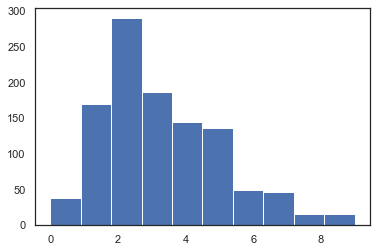

In [19]:
y_class, df_lesion, df_lesion_summary = direct_standardize_labelling(df, num_classes, min_zero=True)

plt.hist(y_class, bins=num_classes)
df_lesion_summary

#### Feature standardization
Preprocess feature set:
1. class label standardization
2. split train test data
3. feature standardization
4. oversampling

X: (1092, 29101)
y: DescribeResult(nobs=1092, minmax=(0.0, 9.0), mean=3.1675824175824174, variance=3.793155286510007, skewness=0.7767155496007653, kurtosis=0.20426355500519122)

x_train: (764, 29101)
x_test: (328, 29101)
y_train_class: DescribeResult(nobs=764, minmax=(0.0, 9.0), mean=3.1714659685863875, variance=3.8565372976607906, skewness=0.814490329127442, kurtosis=0.2548129166645796)
y_test_class: DescribeResult(nobs=328, minmax=(0.0, 9.0), mean=3.158536585365854, variance=3.6567464757216386, skewness=0.6797654272404324, kurtosis=0.06183390146578338)

Oversampled training data: 2060



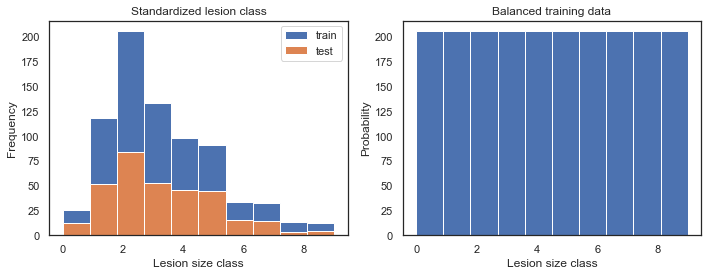

In [20]:
X_train, X_test, y_train, y_test, scaler = preprocess_AtBotData(df, 
                                                                standardize_label_func=direct_standardize_labelling, 
                                                                features_filter=None,
                                                                num_classes=num_classes, verbose="Info", show_figure=True, 
                                                                nb_id=nb_id, random_state=random_state)

In [21]:
df_X_train = pd.DataFrame(data=X_train, columns=gene_names)
df_X_test = pd.DataFrame(data=X_test, columns=gene_names)

In [22]:
# Save training and test splits and scaler 

train_test_data = dict()
train_test_data['df_X_train'] = df_X_train
train_test_data['df_X_test'] = df_X_test
train_test_data['y_train'] = y_train
train_test_data['y_test'] = y_test
train_test_data['scaler'] = scaler

filename = '01_train_test_data.pkl'
f = open(filename, 'wb')
pickle.dump(train_test_data, f)
f.close()

### Preprocess test data (At Only)

In [23]:
filename = "../data/raw/test_set/AtNormTPMReadsStarMapAtSclShared.csv"

df_test_raw = pd.read_csv(filename)
df_test_raw

,Unnamed: 0,Sample,Rep,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01046,AT1G01050,AT1G01060,...,ATMG01380,ATMG01390,ATMG01400,ATMG01410,ATMG09450,ATMG09730,ATMG09740,ATMG09950,ATMG09960,ATMG09980
0,1,s1,Rep1,17.047405,0,0,0.265802,2.169090,6.712978,0,...,0,0.000000,1.311458,0.339060,0,0,0.000000,2.780292,5.635726,14.089316
1,2,s2,Rep2,18.313562,0,0,0.059345,1.808006,3.184929,0,...,0,0.000000,0.000000,0.908413,0,0,0.000000,2.482995,0.000000,0.000000
2,3,s3,Rep3,9.248965,0,0,0.294586,2.991617,3.513294,0,...,0,0.106162,0.000000,0.668047,0,0,0.000000,2.738992,11.104021,0.000000
3,4,s4,Rep1,13.515609,0,0,0.134636,0.000000,0.425038,0,...,0,0.000000,0.000000,0.000000,0,0,29.339438,11.266344,0.000000,0.000000
4,5,s5,Rep2,13.168605,0,0,0.000000,0.000000,0.475804,0,...,0,0.000000,0.000000,0.769023,0,0,13.137473,0.000000,0.000000,6.391203
5,6,s6,Rep3,2.189359,0,0,0.000000,0.000000,0.531135,0,...,0,0.545683,0.000000,1.716905,0,0,0.000000,0.000000,7.134437,21.403312


In [24]:
At_cols = gene_names[:20340]
df_test = df_test_raw.loc[:, At_cols]

# Check for empty cells
print(f"Number of empty cells: {df_test.isnull().sum().sum()}")
df_test

Number of empty cells: 0


,AT1G01010,AT1G01040,AT1G01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,ATMG01320,ATMG01350,ATMG01360,ATMG01370,ATMG01390,ATMG01400,ATMG01410,ATMG09740,ATMG09960,ATMG09980
0,17.047405,0.265802,2.169090,6.712978,0,0,0,486.111130,0,64.629588,...,0,0.000000,5.528989,17.376823,0.000000,1.311458,0.339060,0.000000,5.635726,14.089316
1,18.313562,0.059345,1.808006,3.184929,0,0,0,617.998705,0,10.436567,...,0,2.125852,7.289096,6.650881,0.000000,0.000000,0.908413,0.000000,0.000000,0.000000
2,9.248965,0.294586,2.991617,3.513294,0,0,0,574.234821,0,38.942536,...,0,2.814033,10.374969,22.009755,0.106162,0.000000,0.668047,0.000000,11.104021,0.000000
3,13.515609,0.134636,0.000000,0.425038,0,0,0,166.677720,0,694.675541,...,0,0.964584,8.801831,6.287022,0.000000,0.000000,0.000000,29.339438,0.000000,0.000000
4,13.168605,0.000000,0.000000,0.475804,0,0,0,104.268300,0,933.913005,...,0,0.000000,12.540315,1.407586,0.000000,0.000000,0.769023,13.137473,0.000000,6.391203
5,2.189359,0.000000,0.000000,0.531135,0,0,0,111.381510,0,615.425183,...,0,0.000000,9.665721,14.141474,0.545683,0.000000,1.716905,0.000000,7.134437,21.403312


In [25]:
# Generate standardized test features 
At_X_test = np.zeros((6,len(gene_names)))
At_X_test[:20340, :20340] = df_test.to_numpy()

# scale test features based on training data
At_X_test_scaled = scaler.transform(At_X_test)
print(np.shape(At_X_test_scaled))
At_X_test_scaled

df_At_X_test_scaled = pd.DataFrame(data=At_X_test_scaled, columns=gene_names)
df_At_X_test_scaled

# Numeric comparison with training data
# print(np.shape(X_train))
# X_test

(6, 29101)


,AT1G01010,AT1G01040,AT1G01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,-0.103866,0.543243,1.755117,-1.436727,-0.31523,-0.533842,-0.392093,7.348364,-0.326811,-0.084687,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
1,-0.017771,-0.116853,1.401468,-1.533869,-0.31523,-0.533842,-0.392093,10.258300,-0.326811,-1.073931,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
2,-0.634138,0.635271,2.560708,-1.524828,-0.31523,-0.533842,-0.392093,9.292704,-0.326811,-0.553581,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
3,-0.344018,0.123872,-0.369311,-1.609860,-0.31523,-0.533842,-0.392093,0.300463,-0.326811,11.416231,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
4,-0.367614,-0.306594,-0.369311,-1.608463,-0.31523,-0.533842,-0.392093,-1.076523,-0.326811,15.783294,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
5,-1.114171,-0.306594,-0.369311,-1.606939,-0.31523,-0.533842,-0.392093,-0.919579,-0.326811,9.969587,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829


In [26]:
# Save training and test splits and scaler 

filename = '01_At_test_data.pkl'
f = open(filename, 'wb')
pickle.dump(df_At_X_test_scaled, f)
f.close()

#### Bacteria pathogen: Pto DC3000 (Pseudomonas syringae pv. tomato DC3000)

In [27]:
filename = "../data/raw/test_set/AtNormTPMReadsStarMapAtPsy.csv"

df_test_psy_raw = pd.read_csv(filename)
df_test_psy_raw

,Sample,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,...,ATMG01380,ATMG01390,ATMG01400,ATMG01410,ATMG09450,ATMG09730,ATMG09740,ATMG09950,ATMG09960,ATMG09980
0,SRR6003718,61.739553,0,0,0.202507,0.000000,0.0,0,0,0.0,...,0,0.000000,0.000000,26.865214,0,0,70.607293,42.364376,77.286361,1073.421686
1,SRR6003719,51.449559,0,0,0.000000,2.371129,0.0,0,0,0.0,...,0,0.706805,4.300840,23.350413,0,0,104.474565,82.060022,101.650928,415.844704
2,SRR6003720,48.534762,0,0,0.000000,2.582483,0.0,0,0,0.0,...,0,0.000000,11.710503,18.165561,0,0,68.961851,16.550844,117.421530,721.303686
3,SRR6003721,32.170824,0,0,0.000000,2.652046,0.0,0,0,0.0,...,0,1.185814,4.810377,4.974634,0,0,42.491668,30.594001,134.365543,754.514205
4,SRR6003722,49.964570,0,0,0.000000,0.000000,0.0,0,0,0.0,...,0,0.000000,0.000000,25.713474,0,0,128.120955,35.141748,44.520795,1086.307401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SRR6003813,49.001153,0,0,0.000000,0.000000,0.0,0,0,0.0,...,0,0.000000,12.626541,2.611538,0,0,89.227557,0.000000,43.408001,813.900015
96,SRR6003814,48.080654,0,0,0.000000,0.000000,0.0,0,0,0.0,...,0,0.000000,9.691921,11.693342,0,0,71.343305,0.000000,27.766043,555.320860
97,SRR6003815,53.092144,0,0,0.000000,0.000000,0.0,0,0,0.0,...,0,0.503424,0.000000,9.503663,0,0,27.059040,12.988339,39.491571,724.012144
98,SRR6003816,69.702196,0,0,0.271698,0.000000,0.0,0,0,0.0,...,0,0.000000,2.681098,6.931619,0,0,94.732131,79.574990,0.000000,794.981802


In [32]:
At_cols = gene_names[:20340]
df_test = df_test_psy_raw.loc[:, At_cols]

# Check for empty cells
print(f"Number of empty cells: {df_test.isnull().sum().sum()}")
df_test

Number of empty cells: 0


,AT1G01010,AT1G01040,AT1G01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,ATMG01320,ATMG01350,ATMG01360,ATMG01370,ATMG01390,ATMG01400,ATMG01410,ATMG09740,ATMG09960,ATMG09980
0,61.739553,0.202507,0.000000,0.0,0,0,0.0,98.537393,0.000000,134.401602,...,0,319.183654,3546.411769,200.474279,0.000000,0.000000,26.865214,70.607293,77.286361,1073.421686
1,51.449559,0.000000,2.371129,0.0,0,0,0.0,75.380382,1.164963,187.287736,...,0,346.600548,3727.410705,201.486660,0.706805,4.300840,23.350413,104.474565,101.650928,415.844704
2,48.534762,0.000000,2.582483,0.0,0,0,0.0,96.895765,10.573367,205.675696,...,0,291.907014,3980.195928,147.775395,0.000000,11.710503,18.165561,68.961851,117.421530,721.303686
3,32.170824,0.000000,2.652046,0.0,0,0,0.0,98.026663,5.211925,249.731730,...,0,338.769185,3840.184454,163.896432,1.185814,4.810377,4.974634,42.491668,134.365543,754.514205
4,49.964570,0.000000,0.000000,0.0,0,0,0.0,56.299081,0.000000,135.827478,...,0,318.923394,3935.975568,196.103502,0.000000,0.000000,25.713474,128.120955,44.520795,1086.307401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,49.001153,0.000000,0.000000,0.0,0,0,0.0,30.495494,0.000000,144.799106,...,0,201.678725,3057.057784,121.891217,0.000000,12.626541,2.611538,89.227557,43.408001,813.900015
96,48.080654,0.000000,0.000000,0.0,0,0,0.0,35.220113,0.000000,113.147978,...,0,208.752465,2530.741597,94.784677,0.000000,9.691921,11.693342,71.343305,27.766043,555.320860
97,53.092144,0.000000,0.000000,0.0,0,0,0.0,38.533443,0.000000,137.194079,...,0,222.403066,2652.400872,118.866496,0.503424,0.000000,9.503663,27.059040,39.491571,724.012144
98,69.702196,0.271698,0.000000,0.0,0,0,0.0,37.772938,0.000000,130.464426,...,0,272.517089,2796.212618,121.798454,0.000000,2.681098,6.931619,94.732131,0.000000,794.981802


In [38]:
# TODO: Check
# Generate standardized test features 
At_X_test = np.zeros((len(df_test), len(gene_names)))
At_X_test[:20340, :20340] = df_test.to_numpy()

# scale test features based on training data
At_X_test_scaled = scaler.transform(At_X_test)
print(np.shape(At_X_test_scaled))

df_At_X_test_scaled = pd.DataFrame(data=At_X_test_scaled, columns=gene_names)
df_At_X_test_scaled

# Numeric comparison with training data
# print(np.shape(X_train))
# X_test

(100, 29101)


,AT1G01010,AT1G01040,AT1G01046,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,AT1G01120,...,BCIN18G00020,BCIN18G00060,BCIN18G00145,BCIN18G00180,BCIN18G00190,EFBCT00000013145,EFBCT00000013262,EFBCT00000013292,ENSRNA049512921.T1,ENSRNA049513883.T1
0,2.935074,0.340871,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-1.202969,-0.326811,1.188938,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
1,2.235384,-0.306594,1.952996,-1.621564,-0.31523,-0.533842,-0.392093,-1.713899,-0.045744,2.154326,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
2,2.037186,-0.306594,2.159998,-1.621564,-0.31523,-0.533842,-0.392093,-1.239189,2.224191,2.489982,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
3,0.924484,-0.306594,2.228129,-1.621564,-0.31523,-0.533842,-0.392093,-1.214237,0.930653,3.294185,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
4,2.134409,-0.306594,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-2.134904,-0.326811,1.214966,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.068899,-0.306594,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-2.704229,-0.326811,1.378735,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
96,2.006308,-0.306594,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-2.599986,-0.326811,0.800972,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
97,2.347075,-0.306594,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-2.526881,-0.326811,1.239912,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829
98,3.476512,0.562094,-0.369311,-1.621564,-0.31523,-0.533842,-0.392093,-2.543661,-0.326811,1.117068,...,-0.225481,-0.105304,-0.347602,-0.31731,-0.448732,-0.570666,-0.318129,-0.317477,-0.269608,-0.52829


In [39]:
# Save training and test splits and scaler 

filename = '01_AtPsy_test_data.pkl'
f = open(filename, 'wb')
pickle.dump(df_At_X_test_scaled, f)
f.close()

## Domain Knowledge of Defense Gene List

In [26]:
filename = "../data/raw/domain_knowledge/defencegenelistmerge.csv"
df_defense = pd.read_csv(filename, header=None) #,usecols=[1,2])
df_defense

,0,1,2,3
0,NaN,ACS2,AT1G01480,NaN
1,NaN,NIMIN-1,AT1G02450,NaN
2,NaN,GSTF6,AT1G02930,NaN
3,NaN,AXR3,AT1G04250,Transcription regulator acting as repressor of...
4,NaN,AXR1,AT1G05180,NaN
...,...,...,...,...
158,NaN,ERF104,AT5G61600,NaN
159,NaN,PEP1,AT5G64900,NaN
160,NaN,Arm,AT5G66200,NaN
161,NaN,ABA1,AT5G67030,"abscisic acid biosynthetic process, respons..."


In [27]:
# removing both the leading and the trailing characters (white spaces)
defense_genes = df_defense[2].values[:-1]
defense_gene_list = []
for i in range(len(defense_genes)):
  defense_gene_list.append(str(np.char.strip(defense_genes[i])))

In [28]:
gene_exist = []
for gene in defense_gene_list:
  if gene in list(df):
    gene_exist.append(gene)
#   else:
#     print(gene)

print(len(gene_exist), "genes in feature set out of", len(defense_genes), "genes in defense list.")

130 genes in feature set out of 162 genes in defense list.


In [29]:
# save the valid genes instead
f = open('01_AtDefenseGeneList.pkl', 'wb')
pickle.dump(gene_exist, f)
f.close()

## AtBot Mock Test data

In [30]:
df_mock = pd.read_csv("../data/raw/AtBcMicroArray2012/AtBc16hpiMock_2012_IDConver.csv")
df_mock

,ID_REF,Microarray,GeneID,Description
0,CATMA1a00010,8.358308,AT1G01010,ANAC001 (Arabidopsis NAC domain containing pro...
1,CATMA1a00030,7.202073,AT1G01030,NGA3 (NGATHA3); transcription factor
2,CATMA1a00035,9.661633,AT1G01040,DCL1 (DICER-LIKE1); ATP-dependent helicase/ ri...
3,CATMA1a00040,11.778584,AT1G01050,ATPPA1 (ARABIDOPSIS THALIANA PYROPHOSPHORYLASE...
4,CATMA1a00045,13.740401,AT1G01060,LHY (LATE ELONGATED HYPOCOTYL); DNA binding / ...
...,...,...,...,...
8446,CATMA5A62510,8.892372,AT5G67060,Encodes a bHLH transcription factor that is in...
8447,CATMA5A62520,12.149072,AT5G67070,Member of a diversely expressed predicted pept...
8448,CATMA5A62530,7.894264,AT5G67080,member of MEKK subfamily
8449,CATMA5A62550,6.104490,AT5G67100,Encodes the putative catalytic subunit of the ...


In [31]:
mock_features = df_mock.loc[:,'GeneID']
mock_features.to_list()

print(f'Number of features: {len(mock_features)}')
print(f'Unique features: {len(set(mock_features))}')

gene_names = df.columns[6:].to_list()

ugene_names = [each_string.upper() for each_string in gene_names]
common_features = set(mock_features) & set(ugene_names)
print(f'Intersection: {len(common_features)}')

Number of features: 8451
Unique features: 8451
Intersection: 6258


## The path forward for analysis

For the columns (6 to 29107), we can break these genes into Arabidopsis and Botrytis. I think we probably want to initially seperate these and look at the predictions individually. 

**First**

That is, we should seperate the genes data- Arabidopsis genes (6:20346) and Botrytis (20346:29107), and use then in two seperate models to predict lesion size. 

**Second**

We should then put all the data together, gene data from both organisms, to see if this combined approach influences the lesion prediction. 